In [1]:
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.rcParams["pdf.fonttype"] = 42 

In [3]:
sc.settings.set_figure_params(dpi=120)
sns.set_style("dark")

In [4]:
from sklearn.svm import SVR

def filter_cv_vs_mean(S: np.ndarray, N: int, svr_gamma: float=None, plot: bool=True, min_expr_cells: int=2,
                      max_expr_avg: float=20, min_expr_avg: float=0) -> np.ndarray:
    muS = S.mean(1)
    detected_bool = ((S > 0).sum(1) > min_expr_cells) & (muS < max_expr_avg) & (muS > min_expr_avg)
    
    Sf = S[detected_bool, :]
    mu = Sf.mean(1)
    sigma = Sf.std(1, ddof=1)

    cv = sigma / mu
    log_m = np.log2(mu)
    log_cv = np.log2(cv)
    
    if svr_gamma is None:
        svr_gamma = 150. / len(mu)
    
    svr = SVR(gamma=svr_gamma)
    svr.fit(log_m[:, None], log_cv)
    fitted_fun = svr.predict
    ff = fitted_fun(log_m[:, None])
    score = log_cv - ff

    xnew = np.linspace(np.min(log_m), np.max(log_m))
    ynew = svr.predict(xnew[:, None])

    nth_score = np.sort(score)[::-1][N]
    
    if plot:
        plt.scatter(log_m[score > nth_score], log_cv[score > nth_score], s=3, alpha=0.4, c="tab:red")
        plt.scatter(log_m[score <= nth_score], log_cv[score <= nth_score], s=3, alpha=0.4, c="tab:blue")
        mu_linspace = np.linspace(np.min(log_m), np.max(log_m))
        plt.plot(mu_linspace, fitted_fun(mu_linspace[:, None]), c="k")
        plt.xlabel("log2 mean S")
        plt.ylabel("log2 CV S")
    
    cv_mean_score = np.zeros(detected_bool.shape)
    cv_mean_score[~detected_bool] = np.min(score) - 1e-16
    cv_mean_score[detected_bool] = score
    cv_mean_selected = cv_mean_score >= nth_score
    return cv_mean_selected

In [5]:
adata1 = sc.read_h5ad("D30_Sorted_Joint_Analysis.h5ad")

In [6]:
original_data = sc.read_loom("hESC-RPE_invitro_differentiation.loom")

/opt/anaconda3/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


In [7]:
original_data

AnnData object with n_obs × n_vars = 11791 × 33538
    obs: 'Barcode', 'CellCycleSplicedPhase', 'CellTypeCategory1', 'CellTypeCategory2', 'D07D14IntegratedUMAP1', 'D07D14IntegratedUMAP2', 'Day', 'EqualizedCluster', 'ExpressedGenes', 'IndividualUMAP1', 'IndividualUMAP2', 'JointUMAP0', 'JointUMAP1', 'PC0', 'PC1', 'PercentMito', 'TotalSplicedUMIs', 'TotalUnsplicedUMIs'
    var: 'Accession', 'CellCycleExcluded', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [8]:
adata2 = original_data[original_data.obs["Day"]=="D30"].copy()

In [9]:
adata2

AnnData object with n_obs × n_vars = 1852 × 33538
    obs: 'Barcode', 'CellCycleSplicedPhase', 'CellTypeCategory1', 'CellTypeCategory2', 'D07D14IntegratedUMAP1', 'D07D14IntegratedUMAP2', 'Day', 'EqualizedCluster', 'ExpressedGenes', 'IndividualUMAP1', 'IndividualUMAP2', 'JointUMAP0', 'JointUMAP1', 'PC0', 'PC1', 'PercentMito', 'TotalSplicedUMIs', 'TotalUnsplicedUMIs'
    var: 'Accession', 'CellCycleExcluded', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [10]:
adata2.obs["cell_type"] = adata2.obs["CellTypeCategory2"]
adata2.obs["sample"] = "Unsorted"

In [11]:
adata = adata2.concatenate(adata1)

In [12]:
adata.obs["batch"].value_counts()

1    2220
0    1852
Name: batch, dtype: int64

In [13]:
from collections import Counter
Counter(adata.obs["sample"])

Counter({'Unsorted': 1852, 'CD140b-High': 1486, 'NCAM1-High': 734})

In [14]:
adata

AnnData object with n_obs × n_vars = 4072 × 20310
    obs: 'Barcode', 'CellCycleSplicedPhase', 'CellTypeCategory1', 'CellTypeCategory2', 'D07D14IntegratedUMAP1', 'D07D14IntegratedUMAP2', 'Day', 'EqualizedCluster', 'ExpressedGenes', 'IndividualUMAP1', 'IndividualUMAP2', 'JointUMAP0', 'JointUMAP1', 'PC0', 'PC1', 'PercentMito', 'TotalSplicedUMIs', 'TotalUnsplicedUMIs', 'cell_type', 'sample', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'louvain'
    var: 'Accession-0', 'CellCycleExcluded-0', 'Chromosome-0', 'End-0', 'Start-0', 'Strand-0', 'gene_ids-1', 'feature_types-1'

In [15]:
adata_raw = adata.copy()

In [16]:
sc.pp.filter_genes(adata, min_cells=20)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [17]:
sc.pp.normalize_total(adata)

In [18]:
adata.raw = adata

In [19]:
S_genes_hum = ["MCM5", "PCNA", "TYMS", "FEN1", "MCM2", "MCM4", "RRM1", "UNG", "GINS2", 
            "MCM6", "CDCA7", "DTL", "PRIM1", "UHRF1", "CENPU", "HELLS", "RFC2", 
            "RPA2", "NASP", "RAD51AP1", "GMNN", "WDR76", "SLBP", "CCNE2", "UBR7", 
            "POLD3", "MSH2", "ATAD2", "RAD51", "RRM2", "CDC45", "CDC6", "EXO1", "TIPIN", 
            "DSCC1", "BLM", "CASP8AP2", "USP1", "CLSPN", "POLA1", "CHAF1B", "BRIP1", "E2F8"]
G2M_genes_hum = ["HMGB2", "CDK1", "NUSAP1", "UBE2C", "BIRC5", "TPX2", "TOP2A", "NDC80",
             "CKS2", "NUF2", "CKS1B", "MKI67", "TMPO", "CENPF", "TACC3", "PIMREG", 
             "SMC4", "CCNB2", "CKAP2L", "CKAP2", "AURKB", "BUB1", "KIF11", "ANP32E", 
             "TUBB4B", "GTSE1", "KIF20B", "HJURP", "CDCA3", "JPT1", "CDC20", "TTK",
             "CDC25C", "KIF2C", "RANGAP1", "NCAPD2", "DLGAP5", "CDCA2", "CDCA8", "ECT2", 
             "KIF23", "HMMR", "AURKA", "PSRC1", "ANLN", "LBR", "CKAP5", "CENPE", 
             "CTCF", "NEK2", "G2E3", "GAS2L3", "CBX5", "CENPA"]
sc.tl.score_genes_cell_cycle(adata, s_genes=S_genes_hum, g2m_genes=G2M_genes_hum)

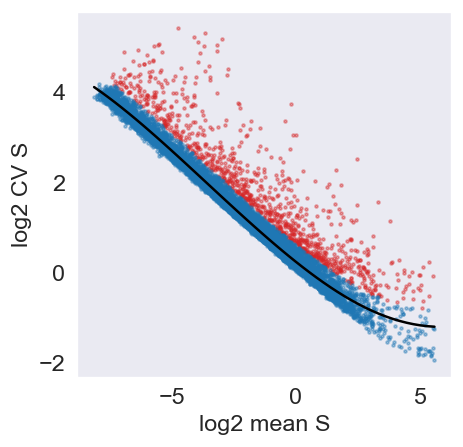

In [20]:
cv_vs_mean_keep = filter_cv_vs_mean(adata.X.toarray().T, N=1000, max_expr_avg=50)

In [21]:
sc.pp.log1p(adata)

In [22]:
adata = adata[:, cv_vs_mean_keep].copy()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [23]:
sc.pp.regress_out(adata, ['S_score'])

... storing 'Barcode' as categorical
... storing 'CellCycleSplicedPhase' as categorical
... storing 'CellTypeCategory1' as categorical
... storing 'CellTypeCategory2' as categorical
... storing 'D07D14IntegratedUMAP1' as categorical
... storing 'D07D14IntegratedUMAP2' as categorical
... storing 'Day' as categorical
... storing 'cell_type' as categorical
... storing 'sample' as categorical
... storing 'louvain' as categorical
... storing 'phase' as categorical
... storing 'Chromosome-0' as categorical
... storing 'Strand-0' as categorical


In [24]:
sc.pp.regress_out(adata, ['G2M_score'])

In [25]:
sc.pp.scale(adata, max_value=10)

In [26]:
sc.tl.pca(adata, svd_solver='arpack')

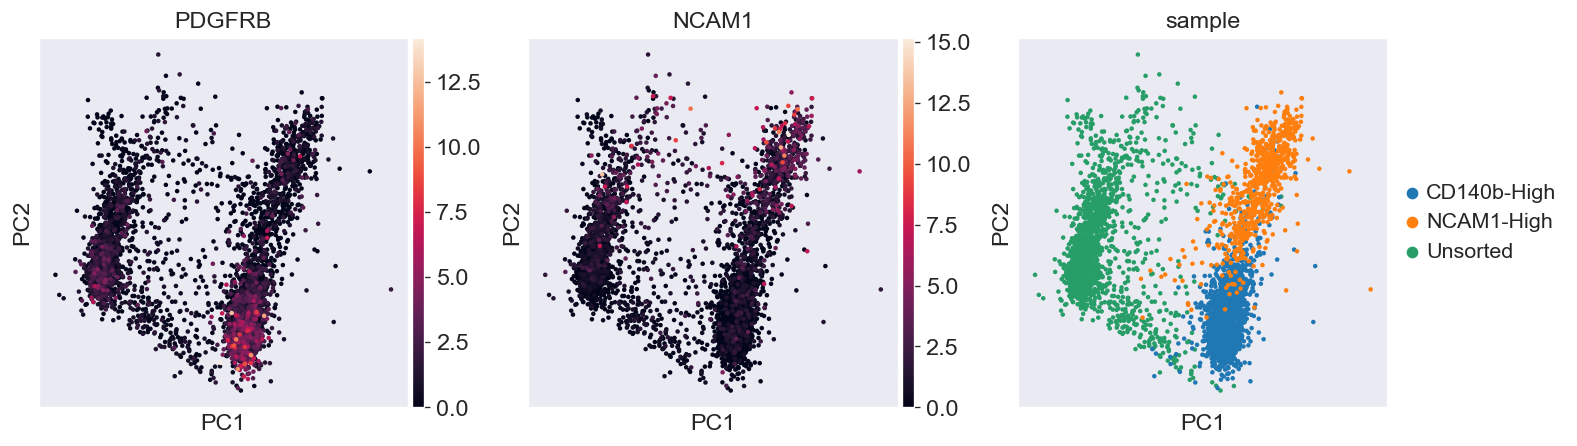

In [27]:
sc.pl.pca(adata, color=['PDGFRB', 'NCAM1', 'sample'])

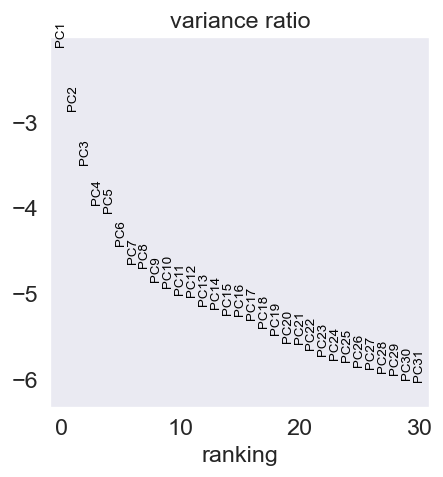

In [28]:
sc.pl.pca_variance_ratio(adata, log=True)

In [29]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=5)

In [30]:
sc.tl.umap(adata, alpha=0.3, min_dist=0.5, random_state=0)

In [31]:
sc.tl.louvain(adata, resolution=1)

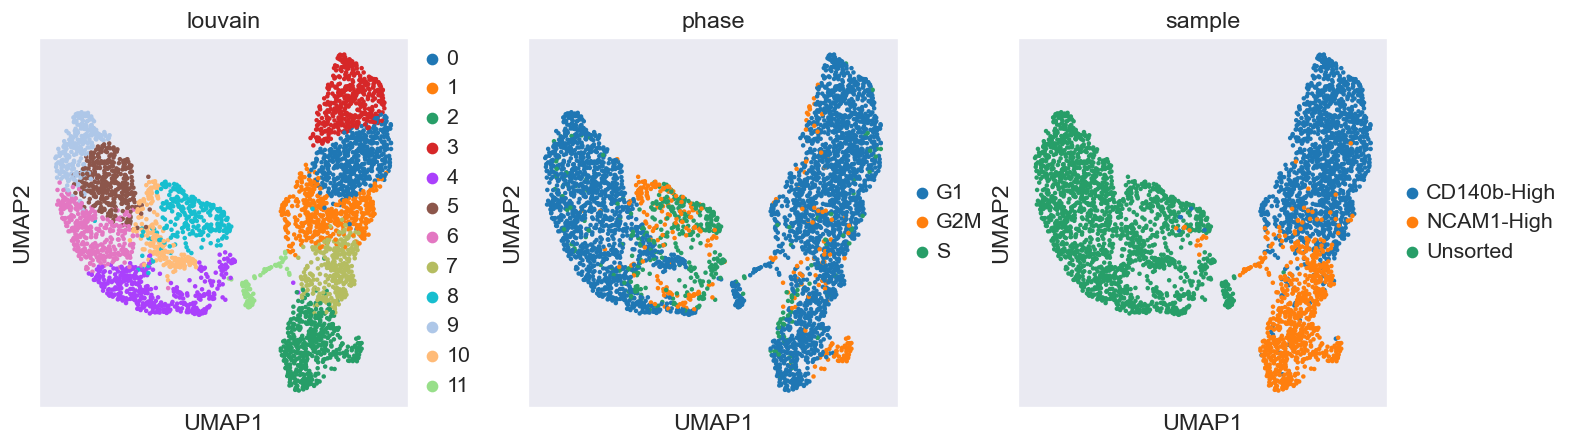

In [32]:
sc.pl.umap(adata, use_raw=True, color=['louvain', "phase", 'sample'], ncols=3)

In [33]:
adata_raw.obsm["X_umap"] = adata.obsm["X_umap"]
adata_raw.obs["louvain"] = adata.obs["louvain"]

In [34]:
adata_raw_norm = adata_raw.copy()
sc.pp.normalize_total(adata_raw_norm)
sc.pp.log1p(adata_raw_norm)

... storing 'Barcode' as categorical
... storing 'CellCycleSplicedPhase' as categorical
... storing 'CellTypeCategory1' as categorical
... storing 'CellTypeCategory2' as categorical
... storing 'D07D14IntegratedUMAP1' as categorical
... storing 'D07D14IntegratedUMAP2' as categorical
... storing 'Day' as categorical
... storing 'cell_type' as categorical
... storing 'sample' as categorical
... storing 'Chromosome-0' as categorical
... storing 'Strand-0' as categorical


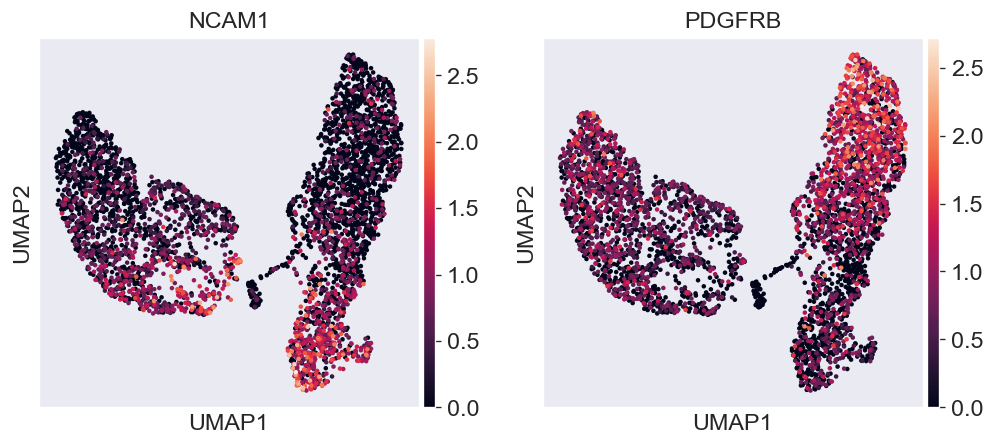

In [35]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["NCAM1", "PDGFRB"], ncols=4)

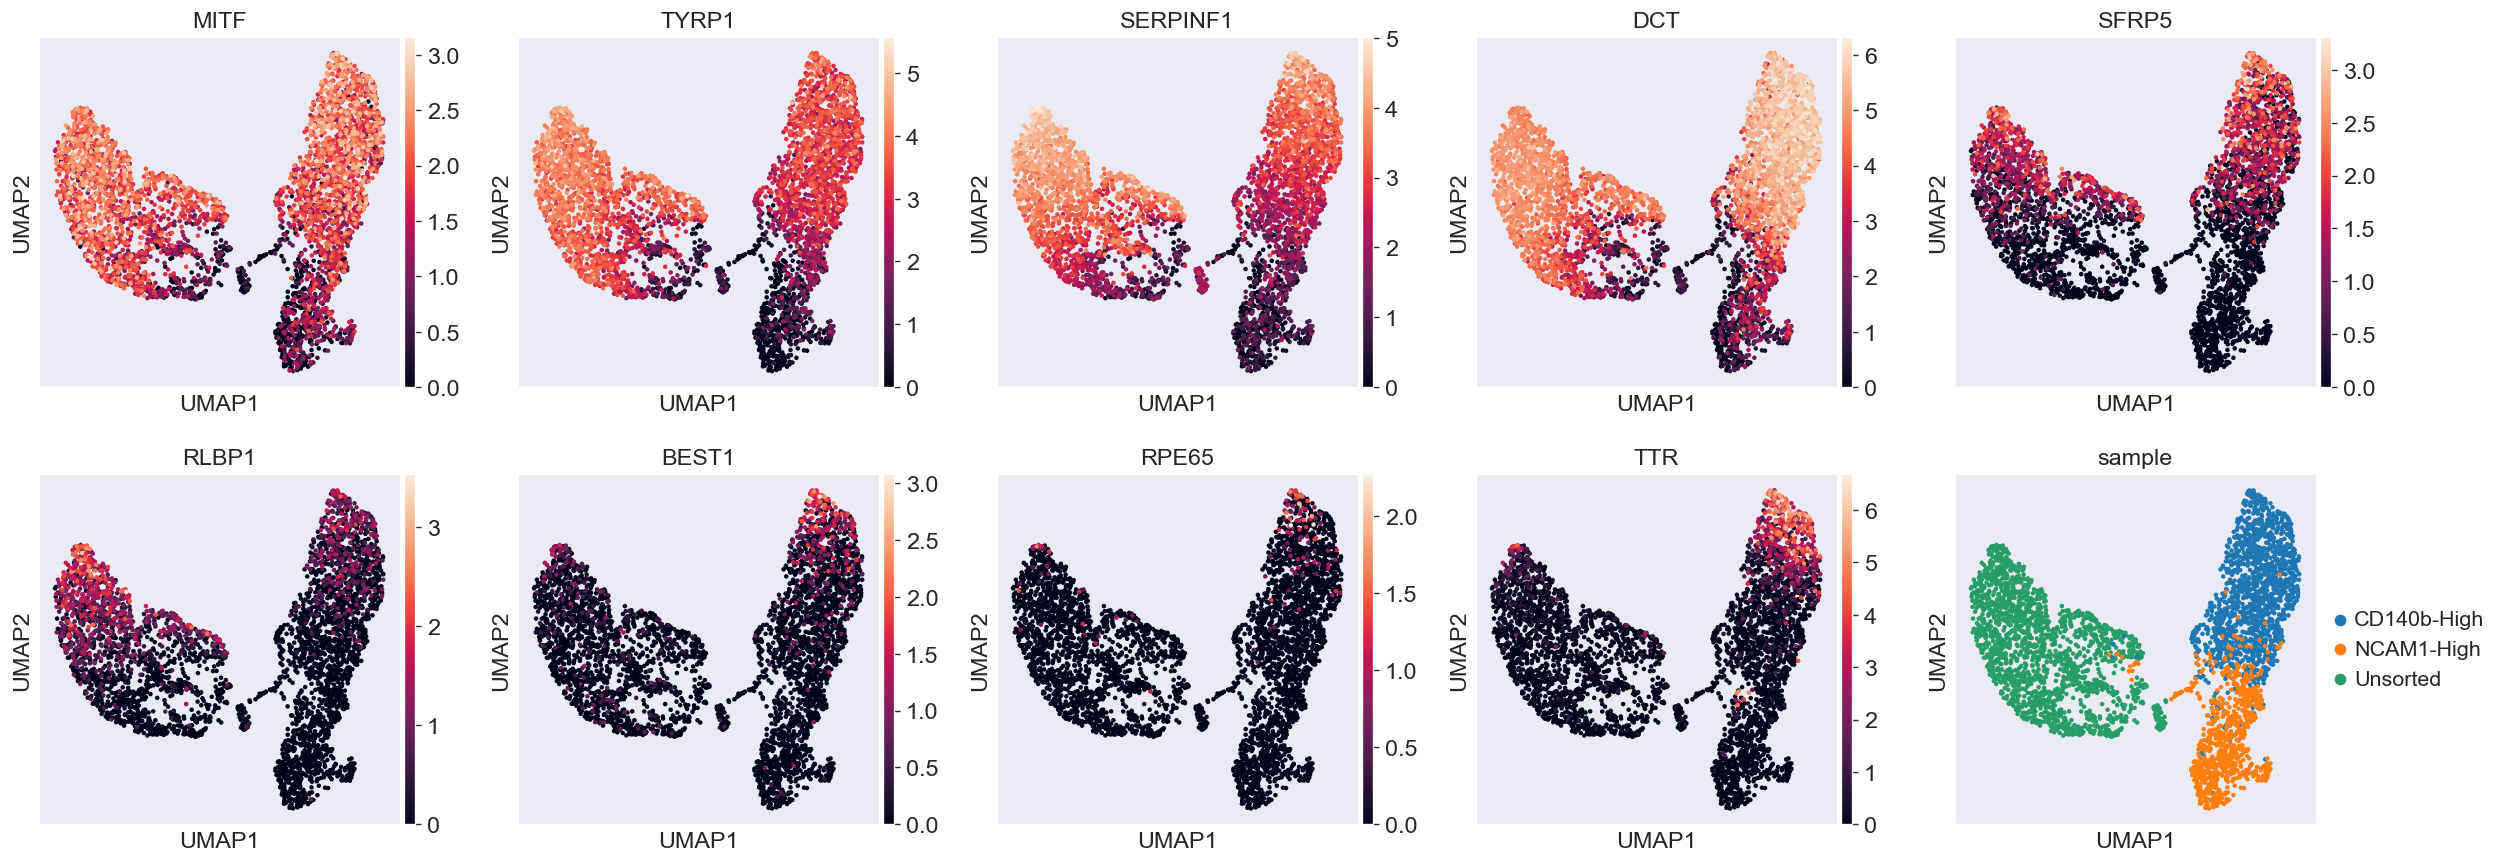

In [36]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["MITF", "TYRP1", "SERPINF1", "DCT", "SFRP5",
                                                 "RLBP1", "BEST1", "RPE65", "TTR", "sample"], ncols=5)

## Integrate to remove batch effects

In [37]:
adata_integrate_init = adata_raw.copy()
sc.pp.filter_genes(adata_integrate_init, min_cells=20)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [38]:
adata_integrate_init = adata_integrate_init[:, cv_vs_mean_keep].copy()

In [39]:
sc.pp.normalize_total(adata_integrate_init)
sc.pp.log1p(adata_integrate_init)

In [40]:
b0 = adata_integrate_init[adata_integrate_init.obs["sample"]=="Unsorted"].copy()
b1 = adata_integrate_init[adata_integrate_init.obs["sample"]!="Unsorted"].copy()

In [41]:
b0

AnnData object with n_obs × n_vars = 1852 × 1001
    obs: 'Barcode', 'CellCycleSplicedPhase', 'CellTypeCategory1', 'CellTypeCategory2', 'D07D14IntegratedUMAP1', 'D07D14IntegratedUMAP2', 'Day', 'EqualizedCluster', 'ExpressedGenes', 'IndividualUMAP1', 'IndividualUMAP2', 'JointUMAP0', 'JointUMAP1', 'PC0', 'PC1', 'PercentMito', 'TotalSplicedUMIs', 'TotalUnsplicedUMIs', 'cell_type', 'sample', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'louvain'
    var: 'Accession-0', 'CellCycleExcluded-0', 'Chromosome-0', 'End-0', 'Start-0', 'Strand-0', 'gene_ids-1', 'feature_types-1', 'n_cells'
    uns: 'log1p'
    obsm: 'X_umap'

In [42]:
b1

AnnData object with n_obs × n_vars = 2220 × 1001
    obs: 'Barcode', 'CellCycleSplicedPhase', 'CellTypeCategory1', 'CellTypeCategory2', 'D07D14IntegratedUMAP1', 'D07D14IntegratedUMAP2', 'Day', 'EqualizedCluster', 'ExpressedGenes', 'IndividualUMAP1', 'IndividualUMAP2', 'JointUMAP0', 'JointUMAP1', 'PC0', 'PC1', 'PercentMito', 'TotalSplicedUMIs', 'TotalUnsplicedUMIs', 'cell_type', 'sample', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'louvain'
    var: 'Accession-0', 'CellCycleExcluded-0', 'Chromosome-0', 'End-0', 'Start-0', 'Strand-0', 'gene_ids-1', 'feature_types-1', 'n_cells'
    uns: 'log1p'
    obsm: 'X_umap'

In [43]:
from miscalg import integration as seurat 
b0_dict = {}
b1_dict = {}
b0_dict["normalized_array"] = np.array(b0.X.toarray())
b1_dict["normalized_array"] = np.array(b1.X.toarray())
b0_dict["GeneID"] = np.array(b0.var.index)
b1_dict["GeneID"] = np.array(b1.var.index)
anchor_pairs, anchor_scores, indicators_pairs = seurat.find_integration_anchors(
    object_list = [b0_dict, b1_dict],
    dims=15,
    anchor_features=b0.shape[1],
    normalization_method=None,
    dim_reduction="crossSVD")
b0_integrated, b1_integrated = seurat.run_integration(data_matrices = (b0_dict["normalized_array"], 
                                                                              b1_dict["normalized_array"]),
                                                             anchor_pairs=anchor_pairs,
                                                             anchor_score = anchor_scores)

adata_integrated =  sc.AnnData(b0_integrated).concatenate(sc.AnnData(b1_integrated))

In [44]:
adata_integrated.obs["S_score"] = [i for i in adata.obs["S_score"]]
adata_integrated.obs["G2M_score"] = [i for i in adata.obs["G2M_score"]]

In [45]:
sc.pp.regress_out(adata_integrated, ['S_score'])
sc.pp.regress_out(adata_integrated, ['G2M_score'])

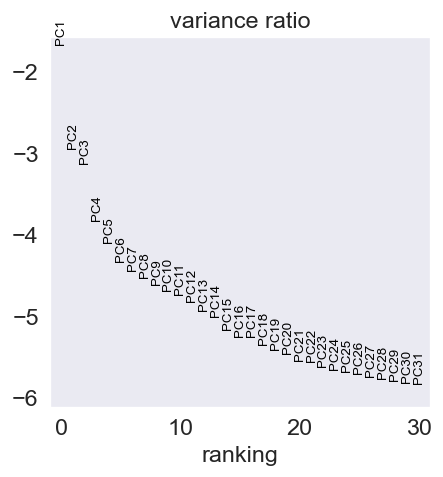

In [46]:
sc.tl.pca(adata_integrated, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_integrated, log=True)

In [47]:
adata_integrated.obs["sample"] = [i for i in adata.obs["sample"]]

In [48]:
sc.pp.neighbors(adata_integrated, n_neighbors=30, n_pcs=5)
sc.tl.umap(adata_integrated, alpha=0.3, min_dist=0.5)
sc.tl.louvain(adata_integrated, resolution=1)
adata_integrated.obs["sample"] = [i for i in adata.obs["sample"]]

... storing 'sample' as categorical


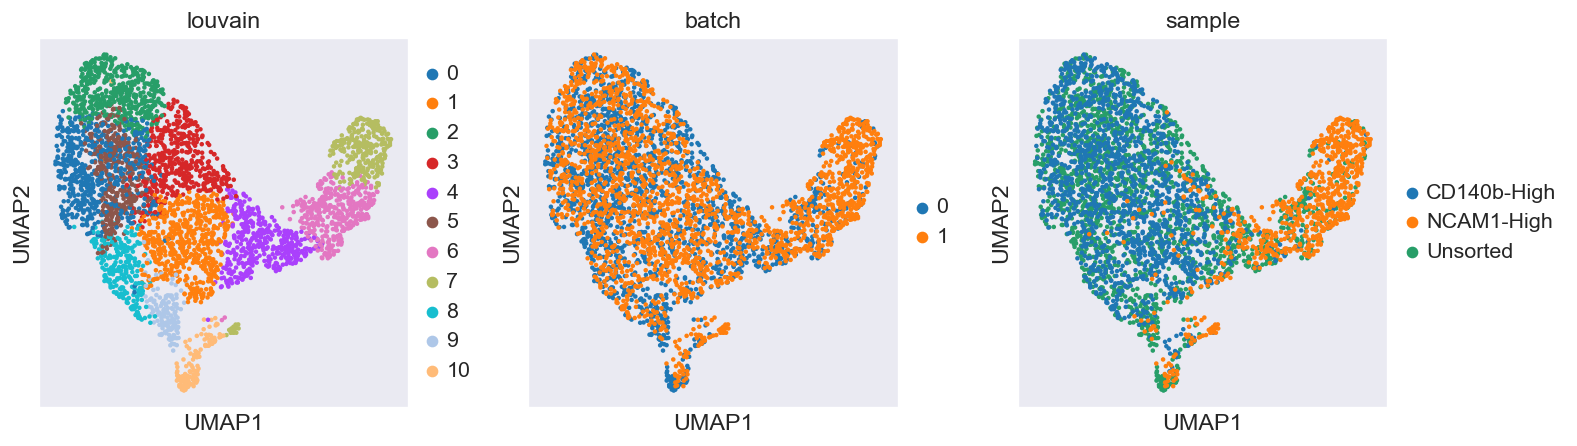

In [49]:
sc.pl.umap(adata_integrated, use_raw=False, color=['louvain', 'batch', 'sample'], ncols=4)

In [50]:
adata_integrated.obs.index = adata_integrate_init.obs.index
adata_integrated.var.index = adata_integrate_init.var.index

In [51]:
n2c = {"Unsorted":"grey", "NCAM1-High":"#ff40ff", "CD140b-High":"#0432ff"}

In [52]:
adata_raw_norm.obsm["X_tsne"] = adata_integrated.obsm["X_umap"]
adata_raw_norm.obs["integrated_louvain"] = [i for i in adata_integrated.obs["louvain"]]

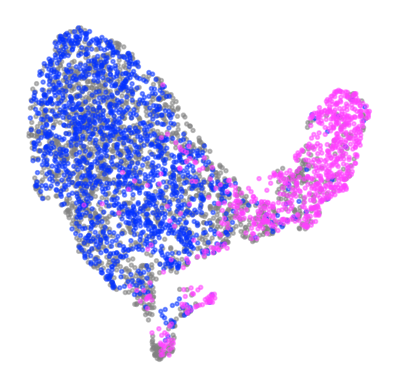

In [53]:
tsne = adata_raw_norm.obsm["X_tsne"]
plt.scatter(tsne[:, 0], tsne[:, 1], c=[n2c[i] for i in adata_integrated.obs["sample"]], s=5, alpha=0.5, rasterized=True)
plt.axis("off")
plt.show()

... storing 'integrated_louvain' as categorical


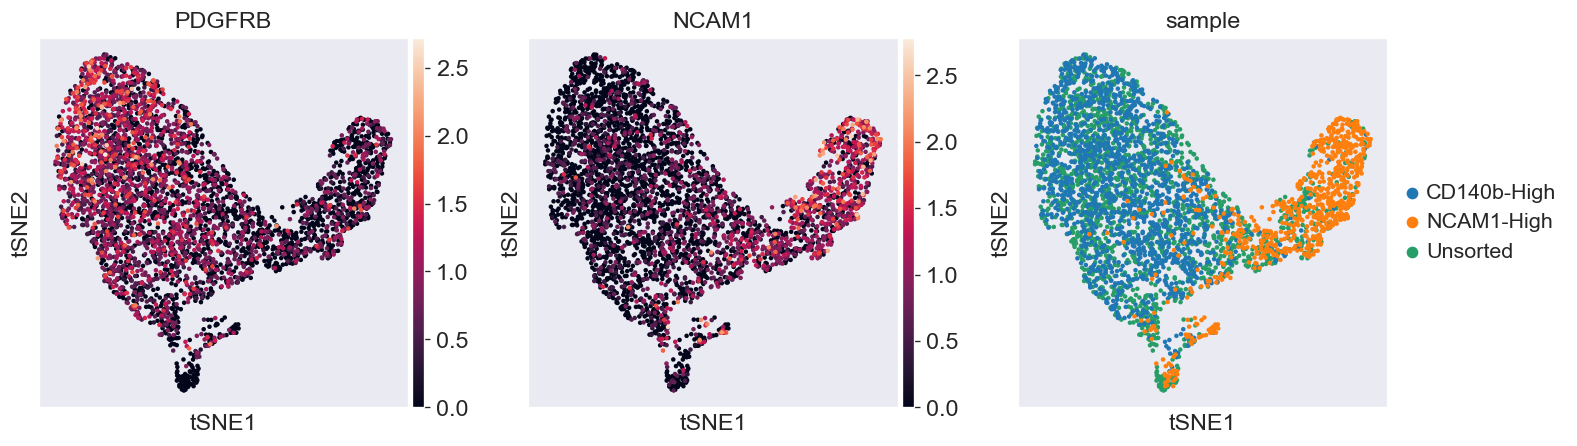

In [54]:
sc.pl.tsne(adata_raw_norm, color=['PDGFRB', 'NCAM1', 'sample'])

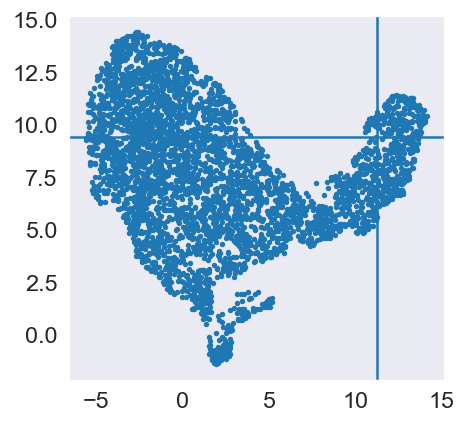

In [55]:
em = adata_raw_norm.obsm["X_tsne"]
plt.scatter(em[:, 0], em[:, 1], s=5)
plt.axvline(11.25)
plt.axhline(9.4)

In [56]:
nl = []
for x,y,l in zip(em[:, 0], em[:, 1], adata_raw_norm.obs["integrated_louvain"]):
    if y<2.5 and l == "7":
        nl.append("13")
    elif x<11.25 and y>9.4 and l=="7":
        nl.append("12")
    elif x>3 and y<2.5 and l in ["10", "4", "6"]:
        nl.append("13")
    else:
        nl.append(l)
adata_raw_norm.obs["integrated_louvain"] = nl

... storing 'integrated_louvain' as categorical


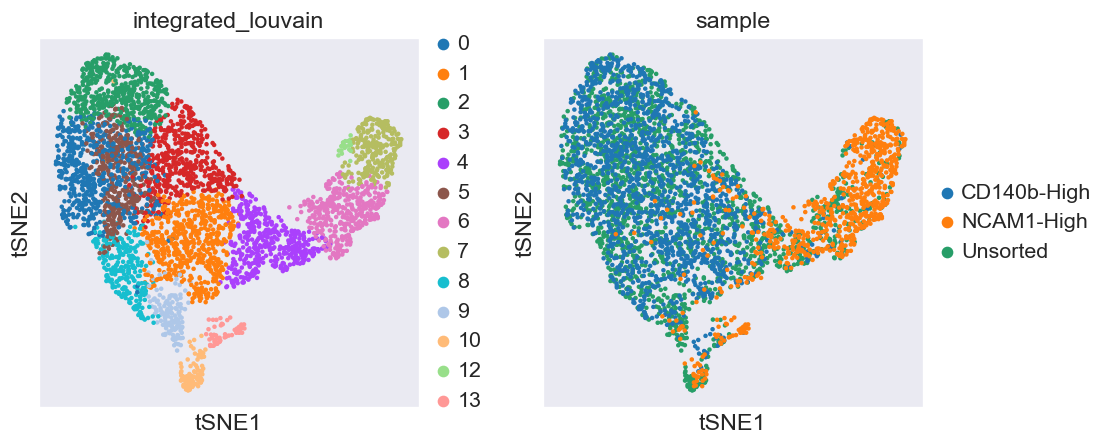

In [57]:
sc.pl.tsne(adata_raw_norm, use_raw=False, color=['integrated_louvain', 'sample'], ncols=4)

In [58]:
louvain2name = {'0':"MidRPE", '1': "EarlyRPE", '10':"NeuralCrest", '2': "LateRPE", '3':"MidRPE",
                '4':"EarlyRPE", '5':"MidRPE", '6':"RetProg", '7':"RetProg", '8': "EMT-RPE", '9':"EMT-RPE",
               "12":"NeuralRet", "13":"Neuronal"}

In [59]:
adata_raw_norm.obs["cell_type_new"] = [louvain2name[i] for i in adata_raw_norm.obs["integrated_louvain"]]

... storing 'cell_type_new' as categorical


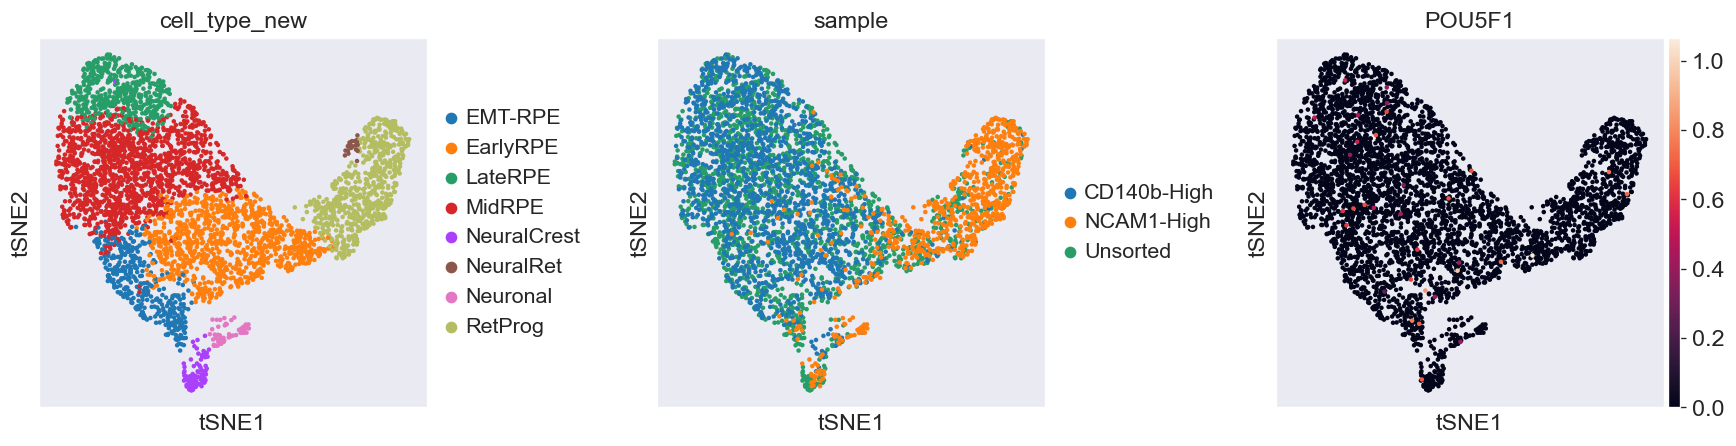

In [60]:
sc.pl.tsne(adata_raw_norm, use_raw=False, color=['cell_type_new', 'sample', "POU5F1"], wspace=0.45, ncols=4)

In [61]:
n2n = {'EMT-RPE':'#1f77b4',
 'EarlyRPE': '#ff7f0e',
 'LateRPE': '#279e68',
 'MidRPE': '#d62728',
 'NeuralCrest': '#aa40fc',
 'NeuralRet': '#8c564b',
 'Neuronal':'#e377c2',
 'RetProg':'#b5bd61'}

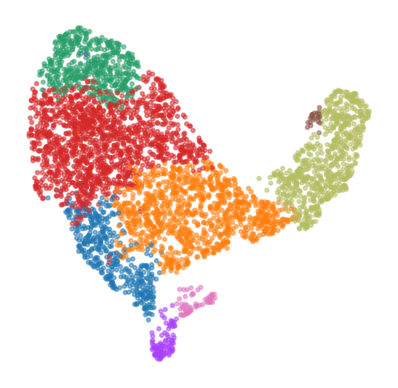

In [62]:
plt.scatter(tsne[:, 0], tsne[:, 1], c=[n2n[i] for i in adata_raw_norm.obs["cell_type_new"]], 
            s=5, alpha=0.5, rasterized=False)
plt.axis("off")
plt.show()

In [63]:
n2n = {'EMT-RPE':0,
 'EarlyRPE': 1,
 'LateRPE': 2,
 'MidRPE': 3,
 'NeuralCrest': 4,
 'NeuralRet': 5,
 'Neuronal':6,
 'RetProg':7}

In [64]:
from miscalg import enrichment
Xgen = adata_raw_norm.X.toarray().T
enrichment_score = enrichment.enrichment_score(Xgen, np.array([n2n[i] for i in adata_raw_norm.obs["cell_type_new"]]))
emarkers = enrichment.extract_enriched(enrichment_score, 
                                      np.array(adata_raw_norm.var.index), n_enriched=30)

In [65]:
edf = pd.DataFrame(emarkers)
edf.head(20)

0        1        2         3        4        5        6        7
0      GJA3      DCC      TTR      BNC1     WNT6    OLIG2    RSPO3     PTH2
1      TP63    LYPD1      RGR     GRIK1    RAB25   POU4F2      ARX  BHLHE22
2      RGS7  B3GALT2  SLC6A13     RLBP1  TACSTD2    ATOH7     EMX2     CRB1
3     WNT2B   SEMA3E     BCO1     UPK3B   TFAP2C  ONECUT2  C1orf61  PCDH11X
4      DLX4      MAL    BEST1   SLC35D3     PKP3     SYT4    FGF17    FEZF2
5      EDN2     ZIC1   PRSS33     INSM1  COL17A1       TH     CER1     FGF9
6      TP73    OLFM3     ERMN     SFRP5    ITGB6    NHLH1     TRDN     SOX2
7   C5orf46     CLMP    SMOC2     GNGT1  S100A14  NEUROD1    GATA6    FGF19
8     ANXA3     LGR6  FAM135B     TFPI2      SFN  NEUROG2   POU3F3    PTPRO
9   STXBP5L    OTOGL    ADTRP    ADAM12     DLX5   ELAVL4    EOMES     SPP1
10     CA10    CYTIP    RPE65       TYR   MGAT4C    STMN2  SPARCL1     VSX2
11    ACTA2   PTCHD4   COL8A1     CPLX3      VIT     SCG3   TM4SF1     DLK1
12     DLX3   BARHL2    ADAD2    RNF128    FXYD3   ARPP21     SOST     DKK1
13   SBSPON      SLN   NPFFR1  SERPINA1    GRHL2    STMN4    FREM1   LRRC4C
14     OXTR    LRRN3   UBAP1L   GALNT14   TMEM40    CPLX2  RIPPLY3    NRCAM
15  S100A10   NPFFR2  SLC13A4        TF    LAMB3  NEUROD4    RSPO2   APCDD1
16     HPGD   PCDH17    CSF1R     TGFBI    FOXC1    CELF3    PITX2    CLRN1
17     NRP2    DCDC1    EPAS1      CD53   PRSS22     ST18     GYPB     RORB
18     CDH1    DACH2     CCNO    ADAM28     KRT5     EBF1   IFI44L   ARPP21
19    IL17B     CDH7   SLC4A5   C8orf34    CLDN6   VSTM2B  FAM181B   AMIGO2

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


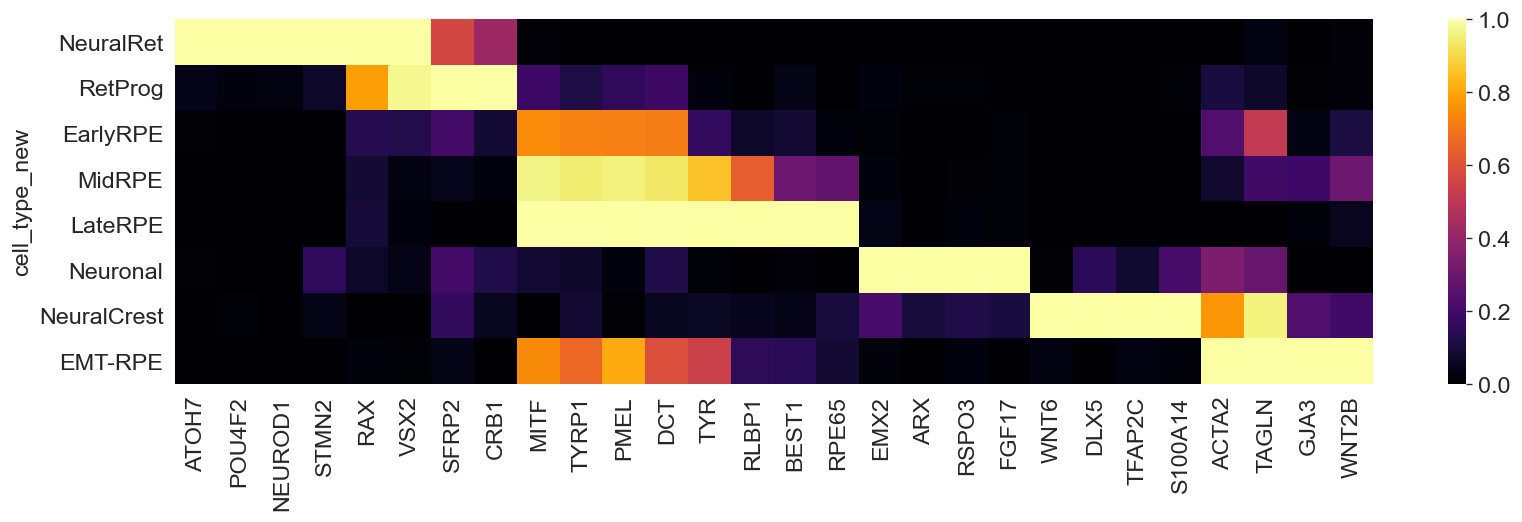

In [66]:
genes = ["ATOH7", "POU4F2", "NEUROD1", "STMN2",
         "RAX", "VSX2", "SFRP2", "CRB1",
         "MITF", "TYRP1", "PMEL", "DCT", 
         "TYR", "RLBP1", "BEST1", "RPE65",
         "EMX2", "ARX", "RSPO3", "FGF17",
         "WNT6", "DLX5", "TFAP2C", "S100A14",
         "ACTA2", "TAGLN", "GJA3", "WNT2B"
        ]

X = pd.DataFrame(adata_raw_norm[:, genes].X.toarray())
X.index = adata_raw_norm.obs["cell_type_new"]
X.columns = genes
X = X.groupby(X.index).mean()

X = X.loc[["NeuralRet", "RetProg", "EarlyRPE", "MidRPE", "LateRPE", "Neuronal", "NeuralCrest", "EMT-RPE"]]

plt.figure(None, (16, 4))
sns.heatmap((X - X.min()) / (X.max() - X.min()), cmap='inferno')
plt.show()

In [67]:
df = adata_raw_norm.obs
df.groupby(["cell_type_new", "sample"])["sample"].value_counts()/df.groupby(["sample"])["sample"].value_counts()*100

sample       sample       cell_type_new
CD140b-High  CD140b-High  EMT-RPE           8.950202
                          EarlyRPE         27.927322
                          LateRPE          17.563930
                          MidRPE           42.866756
                          NeuralCrest       0.874832
                          NeuralRet         0.134590
                          Neuronal          0.740242
                          RetProg           0.942127
NCAM1-High   NCAM1-High   EMT-RPE           2.179837
                          EarlyRPE         20.572207
                          MidRPE            2.588556
                          NeuralCrest       3.269755
                          NeuralRet         2.179837
                          Neuronal          4.495913
                          RetProg          64.713896
Unsorted     Unsorted     EMT-RPE          12.473002
                          EarlyRPE         23.056156
                          LateRPE          11.609071
      

In [68]:
yticks = ["NeuralRet", "RetProg", "EarlyRPE", "MidRPE", "LateRPE", "Neuronal", "NeuralCrest", "EMT-RPE"]
xticks = ["NCAM1-High", "CD140b-High", "Unsorted"]

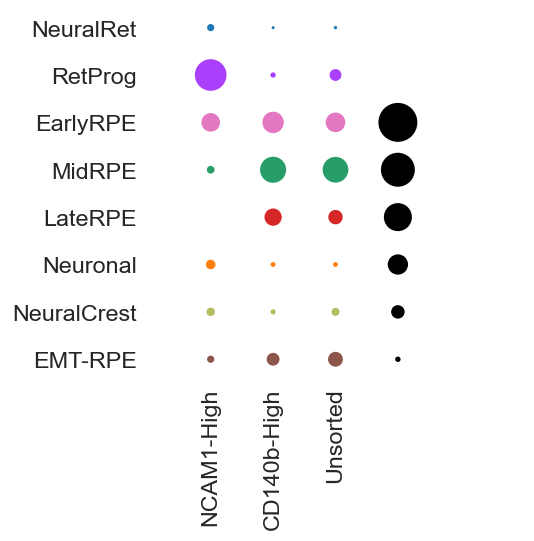

In [69]:
x = [0]*8 + [1]*8 + [2]*8
y = [1, 2, 3, 4, 5, 6, 7, 8] * 3
s = [2.179837, 64.713896, 20.572207, 2.588556, 0, 4.495913, 3.269755, 2.179837] 
s += [0.134590, 0.942127, 27.927322, 42.866756, 17.563930, 0.740242, 0.874832, 8.950202]
s += [0.215983, 7.451404, 23.056156, 41.576674, 11.609071, 0.701944, 2.915767, 12.473002]
c = ['#8c564b', '#b5bd61', '#ff7f0e', '#d62728', '#279e68', '#e377c2', '#aa40fc', '#1f77b4'] * 3
sns.set_style("white")
plt.scatter(x[::-1]+[3]*6, y+[1, 2, 3, 4, 5, 6], s=np.array(s[::-1]+[1, 10, 25, 50, 75, 100])*5, c=c+["black"]*6)
plt.xticks(range(0, 3), xticks, rotation=90)
plt.yticks(range(1, 9), yticks[::-1])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.xlim(-1, 5)
plt.show()

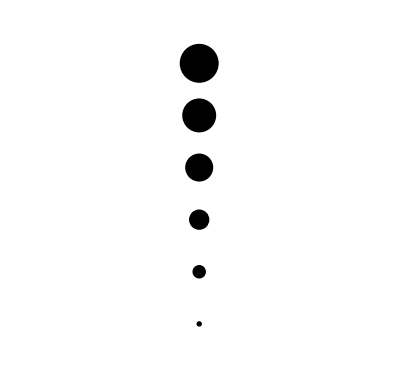

In [70]:
# legend
x = [0]*6
y = [1, 2, 3, 4, 5, 6]
s = [1, 10, 25, 50, 75, 100]
sns.set_style("white")
plt.scatter(x[::-1], y, s=np.array(s)*5, c='black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.ylim(0, 7)
plt.axis("off")
plt.show()

In [71]:
a_tmp = adata_raw_norm[adata_raw_norm.obs["sample"].isin(["NCAM1-High", "CD140b-High"])]

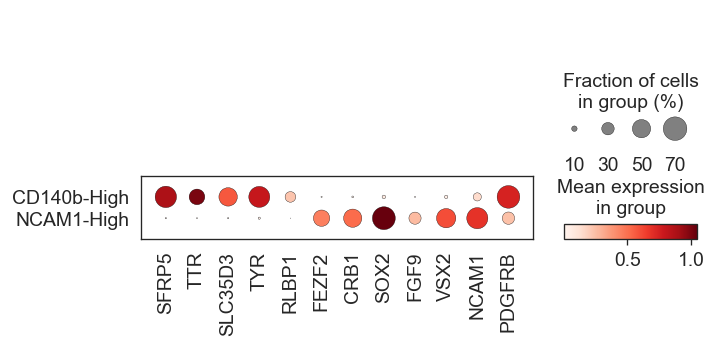

In [72]:
markers =  ["SFRP5", "TTR", "SLC35D3", "TYR", "RLBP1", 
            "FEZF2", "CRB1", "SOX2", "FGF9", "VSX2", "NCAM1", "PDGFRB"]
sc.pl.dotplot(a_tmp, markers, groupby='sample', dendrogram=False)

In [73]:
adata_raw_norm

AnnData object with n_obs × n_vars = 4072 × 20310
    obs: 'Barcode', 'CellCycleSplicedPhase', 'CellTypeCategory1', 'CellTypeCategory2', 'D07D14IntegratedUMAP1', 'D07D14IntegratedUMAP2', 'Day', 'EqualizedCluster', 'ExpressedGenes', 'IndividualUMAP1', 'IndividualUMAP2', 'JointUMAP0', 'JointUMAP1', 'PC0', 'PC1', 'PercentMito', 'TotalSplicedUMIs', 'TotalUnsplicedUMIs', 'cell_type', 'sample', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'louvain', 'integrated_louvain', 'cell_type_new'
    var: 'Accession-0', 'CellCycleExcluded-0', 'Chromosome-0', 'End-0', 'Start-0', 'Strand-0', 'gene_ids-1', 'feature_types-1'
    uns: 'log1p', 'sample_colors', 'integrated_louvain_colors', 'cell_type_new_colors'
    obsm: 'X_umap', 'X_tsne'

In [81]:
adata_raw.write_h5ad("D30_Sorted_Integrated.h5ad")

In [80]:
adata_raw.obsm["X_umap"] = adata_raw_norm.obsm["X_tsne"]